# Прогнозирование оттока клиентов в сети отелей «Как в гостях»

Цель: Нужно разработать систему, которая предсказывает отказ от брони. Если модель покажет, что бронь будет отменена, то клиенту предлагается внести депозит. Размер депозита — 80% от стоимости номера за одни сутки и затрат на разовую уборку. Деньги будут списаны со счёта клиента, если он всё же отменит бронь.

Стоимость номеров отеля:
- категория A: за ночь — 1 000, разовое обслуживание — 400;
- категория B: за ночь — 800, разовое обслуживание — 350;
- категория C: за ночь — 600, разовое обслуживание — 350;
- категория D: за ночь — 550, разовое обслуживание — 150;
- категория E: за ночь — 500, разовое обслуживание — 150;
- категория F: за ночь — 450, разовое обслуживание — 150;
- категория G: за ночь — 350, разовое обслуживание — 150.

В ценовой политике отеля используются сезонные коэффициенты: 
- весной и осенью цены повышаются на 20%, летом — на 40%.

Убытки отеля в случае отмены брони номера — это стоимость одной уборки и одной ночи с учётом сезонного коэффициента.

На разработку системы прогнозирования заложен бюджет — 400 000. 

При этом необходимо учесть, что внедрение модели должно окупиться за тестовый период. Затраты на разработку должны быть меньше той выручки, которую система принесёт компании.

В таблицах hotel_train и hotel_test содержатся одинаковые столбцы:
- id — номер записи;
- adults — количество взрослых постояльцев;
- arrival_date_year — год заезда;
- arrival_date_month — месяц заезда;
- arrival_date_week_number — неделя заезда;
- arrival_date_day_of_month — день заезда;
- babies — количество младенцев;
- booking_changes — количество изменений параметров заказа;
- children — количество детей от 3 до 14 лет;
- country — гражданство постояльца;
- customer_type — тип заказчика:

Contract — договор с юридическим лицом;

Group — групповой заезд;

Transient — не связано с договором или групповым заездом;

Transient-party — не связано с договором или групповым заездом, но связано с бронированием типа Transient.

- days_in_waiting_list — сколько дней заказ ожидал подтверждения;
- distribution_channel — канал дистрибуции заказа;
- is_canceled — отмена заказа;
- is_repeated_guest — признак того, что гость бронирует номер второй раз;
- lead_time — количество дней между датой бронирования и датой прибытия;
- meal — опции заказа:

SC — нет дополнительных опций;

BB — включён завтрак;

HB — включён завтрак и обед;

FB — включён завтрак, обед и ужин.

- previous_bookings_not_canceled — количество подтверждённых заказов у клиента;
- previous_cancellations — количество отменённых заказов у клиента;
- required_car_parking_spaces — необходимость места для автомобиля;
- reserved_room_type — тип забронированной комнаты;
- stays_in_weekend_nights — количество ночей в выходные дни;
- stays_in_week_nights — количество ночей в будние дни;
- total_nights — общее количество ночей;
- total_of_special_requests — количество специальных отметок.

Задачи:

1. открыть файлы с данными;
2. провести предобработку и исследовательский анализ данных;
3. вычислить бизнес-метрику;
4. разработать модель ML;
5. выявить признаки "ненадёжного" клиента;
6. написать общий вывод.

### Шаг 1. Откройте файлы с данными

In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np

from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score
from tqdm import tqdm
from sklearn.metrics import accuracy_score

In [65]:
hotel_train = pd.read_csv('/datasets/hotel_train.csv')
hotel_test = pd.read_csv('/datasets/hotel_test.csv')

In [66]:
hotel_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32412 entries, 0 to 32411
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              32412 non-null  int64  
 1   is_canceled                     32412 non-null  int64  
 2   lead_time                       32412 non-null  float64
 3   arrival_date_year               32412 non-null  int64  
 4   arrival_date_month              32412 non-null  object 
 5   arrival_date_week_number        32412 non-null  int64  
 6   arrival_date_day_of_month       32412 non-null  int64  
 7   stays_in_weekend_nights         32412 non-null  int64  
 8   stays_in_week_nights            32412 non-null  int64  
 9   adults                          32412 non-null  float64
 10  children                        32412 non-null  float64
 11  babies                          32412 non-null  float64
 12  meal                            

In [67]:
hotel_test.head(10)

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,6086,1,74.0,2017,January,1,1,1,0,2.0,...,0,0,0,A,0,0,Transient,0,0,1
1,6087,1,62.0,2017,January,1,1,2,2,2.0,...,0,0,0,A,0,0,Transient,0,1,4
2,6088,1,62.0,2017,January,1,1,2,2,2.0,...,0,0,0,A,0,0,Transient,0,1,4
3,6089,1,71.0,2017,January,1,1,2,2,1.0,...,0,0,0,A,0,0,Transient,0,1,4
4,6090,1,172.0,2017,January,1,1,2,5,2.0,...,0,0,0,A,0,0,Transient,0,0,7
5,6091,1,52.0,2017,January,1,1,2,5,1.0,...,0,0,0,A,0,0,Transient,0,0,7
6,6092,1,143.0,2017,January,1,2,1,1,2.0,...,0,0,0,A,1,0,Transient,0,1,2
7,6093,1,21.0,2017,January,1,2,1,3,2.0,...,0,0,0,A,0,0,Transient,0,1,4
8,6094,1,89.0,2017,January,1,2,1,3,2.0,...,0,0,0,E,0,0,Transient,0,0,4
9,6095,1,48.0,2017,January,1,2,1,4,2.0,...,0,0,0,A,1,0,Transient,0,2,5


In [68]:
hotel_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65229 entries, 0 to 65228
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              65229 non-null  int64  
 1   is_canceled                     65229 non-null  int64  
 2   lead_time                       65229 non-null  float64
 3   arrival_date_year               65229 non-null  int64  
 4   arrival_date_month              65229 non-null  object 
 5   arrival_date_week_number        65229 non-null  int64  
 6   arrival_date_day_of_month       65229 non-null  int64  
 7   stays_in_weekend_nights         65229 non-null  int64  
 8   stays_in_week_nights            65229 non-null  int64  
 9   adults                          65229 non-null  float64
 10  children                        65229 non-null  float64
 11  babies                          65229 non-null  float64
 12  meal                            

In [69]:
hotel_train.head(10)

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,0,0,7.0,2015,July,27,1,0,1,1.0,...,0,0,0,A,0,0,Transient,0,0,1
1,1,0,14.0,2015,July,27,1,0,2,2.0,...,0,0,0,A,0,0,Transient,0,1,2
2,2,0,0.0,2015,July,27,1,0,2,2.0,...,0,0,0,C,0,0,Transient,0,0,2
3,3,0,9.0,2015,July,27,1,0,2,2.0,...,0,0,0,C,0,0,Transient,0,1,2
4,4,1,85.0,2015,July,27,1,0,3,2.0,...,0,0,0,A,0,0,Transient,0,1,3
5,5,1,75.0,2015,July,27,1,0,3,2.0,...,0,0,0,D,0,0,Transient,0,0,3
6,6,1,23.0,2015,July,27,1,0,4,2.0,...,0,0,0,E,0,0,Transient,0,0,4
7,7,0,18.0,2015,July,27,1,0,4,2.0,...,0,0,0,G,1,0,Transient,0,1,4
8,8,0,68.0,2015,July,27,1,0,4,2.0,...,0,0,0,D,0,0,Transient,0,3,4
9,9,0,37.0,2015,July,27,1,0,4,2.0,...,0,0,0,E,0,0,Contract,0,0,4


In [70]:
hotel_test.describe()

,id,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights
count,32412.000000,32412.000000,32412.000000,32412.0,32412.000000,32412.000000,32412.000000,32412.00000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000
mean,60131.505183,0.388467,97.587869,2017.0,17.804054,15.656948,0.867888,2.34009,1.858602,0.083765,0.005523,0.031377,0.011601,0.171418,0.216741,0.262341,0.046248,0.657781,3.207979
std,29953.586177,0.487409,86.507146,0.0,9.177384,8.766429,0.853394,1.37517,0.489341,0.343470,0.075757,0.174338,0.180473,1.875170,0.640551,4.733027,0.219367,0.834341,1.738683
min,6086.000000,0.000000,0.000000,2017.0,1.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,45291.750000,0.000000,23.000000,2017.0,10.000000,8.000000,0.000000,1.00000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,53394.500000,0.000000,76.000000,2017.0,18.000000,15.500000,1.000000,2.00000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
75%,89800.250000,1.000000,155.000000,2017.0,25.000000,23.000000,2.000000,3.00000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000
max,97903.000000,1.000000,373.000000,2017.0,35.000000,31.000000,4.000000,6.00000,4.000000,3.000000,2.000000,1.000000,6.000000,72.000000,18.000000,223.000000,8.000000,5.000000,10.000000


In [71]:
hotel_train.describe()

,id,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights
count,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000
mean,43544.069172,0.368609,96.337917,2015.719021,31.339772,15.847813,0.825185,2.224793,1.836576,0.074890,0.007236,0.027151,0.128915,0.107713,0.194269,3.334422,0.056647,0.512763,3.049978
std,25614.858971,0.482431,96.127545,0.449481,13.464024,8.748182,0.853477,1.354992,0.480245,0.334243,0.098790,0.162523,0.965326,1.326638,0.593838,18.239606,0.232094,0.752590,1.738108
min,0.000000,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,19108.000000,0.000000,17.000000,2015.000000,21.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,40554.000000,0.000000,64.000000,2016.000000,34.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
75%,67414.000000,1.000000,151.000000,2016.000000,42.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000
max,84121.000000,1.000000,374.000000,2016.000000,53.000000,31.000000,4.000000,6.000000,4.000000,3.000000,10.000000,1.000000,26.000000,58.000000,17.000000,259.000000,3.000000,5.000000,10.000000


Импортированы необходимые библиотеки, получена первичная информация о двух датафрейма для проведения дальнейшего анализа.

### Шаг 2. Предобработка и исследовательский анализ данных

In [72]:
#hotel_test.isnull().sum()

In [73]:
hotel_test.duplicated().sum()

0

In [74]:
#hotel_train.isnull().sum()

In [75]:
hotel_train.duplicated().sum()

0

Пропусков и явных дубликатов в датафреймах нет

In [76]:
hotel_train['customer_type'].unique()

array(['Transient', 'Contract', 'Transient-Party', 'Group'], dtype=object)

In [77]:
hotel_test ['customer_type'].unique()

array(['Transient', 'Transient-Party', 'Contract', 'Group'], dtype=object)

In [78]:
hotel_train['meal'].unique()

array(['BB       ', 'FB       ', 'HB       ', 'SC       ', 'SC'],
      dtype=object)

In [79]:
hotel_train['meal'] = hotel_train['meal'].str.strip()

In [80]:
hotel_train['meal'].unique()

array(['BB', 'FB', 'HB', 'SC'], dtype=object)

In [81]:
hotel_test['meal'].unique()

array(['BB       ', 'HB       ', 'SC', 'FB       ', 'SC       '],
      dtype=object)

In [82]:
hotel_test['meal'] = hotel_test['meal'].str.strip()

In [83]:
hotel_test['meal'].unique()

array(['BB', 'HB', 'SC', 'FB'], dtype=object)

Проверка на неявные дубликаты и замена при необходимости.

In [84]:
hotel_test['adults'].unique()

array([2., 1., 3., 4., 0.])

In [85]:
hotel_train['adults'].unique()

array([1., 2., 3., 4., 0.])

In [86]:
hotel_test['arrival_date_year'].unique()

array([2017])

In [87]:
hotel_train['arrival_date_year'].unique()

array([2015, 2016])

In [88]:
hotel_test['arrival_date_month'].unique()

array(['January', 'February', 'March', 'April', 'May', 'June', 'July',
       'August'], dtype=object)

In [89]:
hotel_train['arrival_date_month'].unique()

array(['July', 'August', 'September', 'October', 'November', 'December',
       'January', 'February', 'March', 'April', 'May', 'June'],
      dtype=object)

In [90]:
hotel_test['arrival_date_day_of_month'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 11, 12, 13, 14, 16, 17, 19, 20,
       21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 10, 15, 18])

In [91]:
hotel_train['arrival_date_day_of_month'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

In [92]:
hotel_test['babies'].unique()

array([0., 1., 2.])

In [93]:
hotel_train['babies'].unique()

array([ 0.,  1.,  2., 10.,  9.])

In [94]:
print ((hotel_train['babies'] == 10).sum())

1


In [95]:
print ((hotel_train['babies'] == 9).sum())

1


Эти данные являются выбросами, заменим 10 на 1, а 9 на 0

In [96]:
hotel_train['babies'] = hotel_train['babies'].replace({10: 1, 9: 0})

In [97]:
hotel_train['babies'].unique()

array([0., 1., 2.])

замена прошла успешно

In [98]:
hotel_train['booking_changes'].unique()

array([ 0,  1,  3,  2,  4,  5,  6, 10, 16,  7,  9, 13,  8, 14, 15, 17])

In [99]:
hotel_test['booking_changes'].unique()

array([ 0,  1,  2,  3,  4,  6,  5,  7, 18, 15, 16, 14,  8, 11, 10])

In [100]:
hotel_train['children'].unique()

array([0., 1., 2., 3.])

In [101]:
hotel_test['children'].unique()

array([0., 2., 1., 3.])

In [102]:
hotel_train['country'].unique()

array(['GBR', 'PRT', 'ESP', 'IRL', 'FRA', 'ROU', 'NOR', 'USA', 'DEU',
       'BEL', 'CHE', 'CN', 'GRC', 'NLD', 'ARG', 'RUS', 'SWE', 'POL',
       'EST', 'CZE', 'ITA', 'FIN', 'DNK', 'MOZ', 'BWA', 'LUX', 'BRA',
       'SVN', 'ALB', 'CHN', 'MEX', 'MAR', 'SMR', 'LVA', 'CHL', 'AUT',
       'LTU', 'TUR', 'ISR', 'IND', 'CYM', 'AUS', 'CPV', 'ZWE', 'DZA',
       'KOR', 'CRI', 'HUN', 'TUN', 'ARE', 'HRV', 'HKG', 'IRN', 'GIB',
       'JEY', 'URY', 'ZAF', 'COL', 'GGY', 'KWT', 'CYP', 'KAZ', 'THA',
       'DOM', 'NGA', 'BLR', 'VEN', 'UKR', 'ARM', 'JPN', 'LKA', 'MYS',
       'BIH', 'MUS', 'OMN', 'SUR', 'JAM', 'BGR', 'CIV', 'SRB', 'JOR',
       'SYR', 'PHL', 'PRI', 'SGP', 'BDI', 'LBN', 'AGO', 'VNM', 'AZE',
       'PLW', 'NZL', 'EGY', 'MDV', 'CMR', 'MLT', 'SVK', 'MWI', 'STP',
       'TWN', 'IDN', 'SEN', 'PER', 'SAU', 'KNA', 'ETH', 'ECU', 'IRQ',
       'AND', 'HND', 'PAK', 'GEO', 'ZMB', 'QAT', 'KHM', 'MCO', 'BGD',
       'ISL', 'UZB', 'IMN', 'TJK', 'NIC', 'BEN', 'MAC', 'VGB', 'TZA',
       'GAB', 'MKD', 

In [103]:
hotel_test['country'].unique()

array(['PRT', 'AUT', 'BEL', 'DEU', 'BRA', 'GBR', 'ESP', 'FRA', 'ITA',
       'LUX', 'CHE', 'EST', 'NGA', 'IRL', 'CN', 'POL', 'AUS', 'NLD',
       'KOR', 'ROU', 'USA', 'CHL', 'DNK', 'FIN', 'RUS', 'SWE', 'HUN',
       'HRV', 'MDV', 'ZAF', 'ISR', 'NOR', 'CHN', 'ARE', 'MAR', 'COL',
       'FJI', 'LVA', 'LBN', 'PHL', 'HKG', 'SYC', 'GIB', 'AGO', 'MYS',
       'MDG', 'IDN', 'LTU', 'ISL', 'TUR', 'ARG', 'JPN', 'SVN', 'SVK',
       'BGR', 'CAF', 'JAM', 'UZB', 'UKR', 'IND', 'CZE', 'URY', 'NZL',
       'NPL', 'SRB', 'CPV', 'IRN', 'KAZ', 'BHS', 'SUR', 'CUB', 'PAK',
       'MAC', 'CYP', 'JOR', 'GRC', 'KWT', 'TWN', 'VNM', 'SGP', 'DOM',
       'VEN', 'SEN', 'BLR', 'TZA', 'LIE', 'GNB', 'SAU', 'DZA', 'PER',
       'AZE', 'EGY', 'ETH', 'KEN', 'THA', 'MLT', 'ECU', 'AND', 'IMN',
       'BHR', 'TUN', 'MNE', 'MEX', 'BEN', 'MOZ', 'UMI', 'JEY', 'MYT',
       'QAT', 'BGD', 'GAB', 'CIV', 'ZWE', 'GTM', 'ALB', 'GHA', 'ATA',
       'ASM', 'PAN', 'CRI', 'MCO', 'MUS', 'SYR', 'TGO', 'IRQ', 'LKA',
       'BIH', 'PRY', 

In [104]:
hotel_train['days_in_waiting_list'].unique()

array([  0,  50,  47,  65, 122,  75, 101, 150, 125,  22, 142,   2,  13,
        44,  38,  48,  33,  77,  21,  80,  59,  40,  58,  89,  53,  49,
        60,  69,  87,  91,  57,  99, 111,  79,  98,  85,  63,  15,   3,
        20,  93,   4,  41,  34, 224,  31,  39,  56, 187, 176,  71,  55,
        96, 236, 259, 207, 215, 160, 120,  30,  32,  27,  62,  24, 108,
       147,   5,  14, 107,  70,   8,  35, 178, 174, 162,  68,  11, 193,
        10,  76,  17,  45,   6,  19,  28,  42,  25,  46,   9,   1,  43,
        72,  12,  61,  81,  74, 167])

In [105]:
hotel_test['days_in_waiting_list'].unique()

array([  0,  14,  60, 100, 121,  61,   5,   1, 107,  43, 122,  83,   4,
       113,  18,  20, 185,  93, 109,  34,   6,  13,   8, 154,  64,  99,
        76,  16,  22,  28,  21,   9, 165,   2,  44,  17,  53,  38,  50,
       111,  25,  46,   7,  47,  27,  49,  84,  30, 175, 183,  39,  56,
        31,  10,  15,  23,  63,  33,  32,  11,  35, 117,  57,  12,  80,
        71,  54,  59,  26,  73, 223, 105,  65,  36,  98])

In [106]:
hotel_train['distribution_channel'].unique()

array(['Direct', 'TA/TO', 'Corporate', 'GDS'], dtype=object)

In [107]:
hotel_test['distribution_channel'].unique()

array(['TA/TO', 'Direct', 'Corporate', 'GDS'], dtype=object)

In [108]:
hotel_train['is_canceled'].unique()

array([0, 1])

In [109]:
hotel_test['is_canceled'].unique()

array([1, 0])

In [110]:
hotel_train['is_repeated_guest'].unique()

array([0, 1])

In [111]:
hotel_test['is_repeated_guest'].unique()

array([0, 1])

In [112]:
hotel_train['lead_time'].unique()

array([  7.,  14.,   0.,   9.,  85.,  75.,  23.,  18.,  68.,  37.,  72.,
        48.,  77.,  99.,  40.,  15.,  36.,  70.,  45.,  16., 107.,  47.,
        96., 113.,  50.,   3.,   1.,  10.,   5.,  17.,  93.,  71.,  63.,
        62., 101.,   2.,  81.,  12., 109., 102.,   4.,  92.,  95.,  86.,
        78.,  29.,  30.,  51.,  33.,   8., 100.,  80.,  97.,  64.,  90.,
        27.,  82.,  94., 115., 111.,  98.,  66., 104.,  65.,  55.,  21.,
        88.,  43.,  54., 280.,  24., 103., 249.,  13.,  79.,  35.,  31.,
        34.,  44., 304., 117.,  84., 110.,  59., 116.,  91.,  42.,  60.,
       321.,  32.,  56.,  41.,  76.,  49.,  73., 112.,  39.,  58.,  57.,
        19.,  53.,  38.,   6., 108.,  26., 123.,  28., 118.,  46.,  69.,
        52.,  89.,  61.,  22.,  67., 105.,  25.,  11.,  87., 299.,  74.,
       298., 119.,  20.,  83., 136., 129., 124., 130., 131., 139., 122.,
       106., 137., 120., 135., 150., 143., 151., 126., 147., 128., 156.,
       132., 164., 159., 161., 333., 149., 154., 29

In [113]:
hotel_test['lead_time'].unique()

array([ 74.,  62.,  71., 172.,  52., 143.,  21.,  89.,  48.,  31.,  20.,
       173.,  23.,  46., 149.,  44.,  68.,   6.,  43., 112.,  59.,  93.,
         4., 115., 187.,  11.,   2.,  15.,  66., 113., 125., 161., 154.,
         1.,   0.,  35.,  37.,  60., 129.,  78.,  10.,  82.,   8.,  22.,
        33., 108.,  87., 106.,  45.,  40.,  17.,   5.,  16.,   3.,  41.,
       135., 123., 128.,  47.,  12., 124., 160.,  58.,  65., 281.,  24.,
        30.,  27.,   9.,  94., 219.,  84.,  79.,  72.,  36., 292., 186.,
        85., 169., 166.,  28.,  83., 111.,  54., 200.,  80., 102.,  95.,
       170., 307., 298.,  55.,  77.,  32.,  25., 238.,   7.,  19., 211.,
       137.,  39.,  18., 206.,  42., 179., 205., 142.,  38.,  92.,  56.,
        29., 119.,  73., 320.,  34., 127.,  69.,  13., 140.,  14., 164.,
        51.,  70., 120.,  76., 105.,  50., 191.,  26.,  75., 116., 184.,
        53.,  49.,  63., 194., 167., 312., 171., 218.,  86., 100., 146.,
        64., 148.,  81.,  88.,  57., 339., 332., 13

In [114]:
hotel_train['previous_bookings_not_canceled'].unique()

array([ 0,  1,  2,  3,  4,  5,  6, 10, 12, 13, 15, 21,  7,  9,  8, 11, 14,
       18, 22, 16, 17, 19, 20, 23, 24, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 47, 48, 49, 50, 51, 52,
       53, 54, 55, 56, 57, 58, 25])

In [115]:
hotel_test['previous_bookings_not_canceled'].unique()

array([ 0,  3,  2,  5,  6,  7,  8, 10, 11, 12,  4,  1,  9, 25, 27, 28, 30,
       13, 14, 23, 24, 26, 16, 15, 17, 18, 58, 59, 60, 61, 62, 63, 64, 65,
       66, 67, 68, 69, 70, 71, 72, 19, 29, 20, 21, 22])

In [116]:
hotel_train['required_car_parking_spaces'].unique()

array([0, 1, 2, 3])

In [117]:
hotel_test['required_car_parking_spaces'].unique()

array([0, 1, 2, 8, 3])

In [118]:
rows_for_8 = hotel_test[hotel_test['required_car_parking_spaces'] == 8]

In [119]:
print(f"Количество строк со значением 8: {rows_for_8.shape[0]}")


Количество строк со значением 8: 2


In [120]:
display(rows_for_8)

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
2549,17717,0,26.0,2017,March,11,14,0,5,2.0,...,1,0,2,E,1,0,Transient-Party,8,1,5
2550,17718,0,138.0,2017,March,12,19,2,2,2.0,...,1,0,2,E,1,122,Transient-Party,8,0,4


Вряд ли у клиента 8 машин под каждый день недели, поэтому, скорее всего, произошла ошибка при указании необходимых машин. По полученным данным оказалось, что там 2 гостя и 1 возможный приглашенный гость. Следовательно, необходимо заменить 8 на 3.

In [121]:
hotel_test['required_car_parking_spaces'] = hotel_test['required_car_parking_spaces'].replace(8, 3)

In [122]:
hotel_test['required_car_parking_spaces'].unique()

array([0, 1, 2, 3])

In [123]:
hotel_train['reserved_room_type'].unique()

array(['A               ', 'C               ', 'D               ',
       'E               ', 'G               ', 'F               ',
       'B               '], dtype=object)

In [124]:
hotel_test['reserved_room_type'].unique()

array(['A               ', 'E               ', 'G               ',
       'D               ', 'F               ', 'C               ',
       'B               '], dtype=object)

In [125]:
hotel_test['reserved_room_type'] = hotel_test['reserved_room_type'].str.strip()
hotel_train['reserved_room_type'] = hotel_train['reserved_room_type'].str.strip()

In [126]:
hotel_train['reserved_room_type'].unique()

array(['A', 'C', 'D', 'E', 'G', 'F', 'B'], dtype=object)

In [127]:
hotel_test['reserved_room_type'].unique()

array(['A', 'E', 'G', 'D', 'F', 'C', 'B'], dtype=object)

Убрали лишние пробелы

In [128]:
hotel_train['stays_in_week_nights'].unique()

array([1, 2, 3, 4, 5, 6, 0])

In [129]:
hotel_test['stays_in_week_nights'].unique()

array([0, 2, 5, 1, 3, 4, 6])

In [130]:
hotel_train['stays_in_weekend_nights'].unique()

array([0, 2, 1, 4, 3])

In [131]:
hotel_test['stays_in_weekend_nights'].unique()

array([1, 2, 0, 4, 3])

In [132]:
hotel_train['total_nights'].unique()

array([ 1,  2,  3,  4,  6,  7,  5,  8, 10,  9])

In [133]:
hotel_test['total_nights'].unique()

array([ 1,  4,  7,  2,  5,  6,  3,  8,  9, 10])

In [134]:
hotel_train['total_of_special_requests'].unique()

array([0, 1, 3, 2, 4, 5])

In [135]:
hotel_test['total_of_special_requests'].unique()

array([0, 1, 2, 3, 4, 5])

Проверка странных значений в столбцах закончена

Проведем проверку на строки с заселением людей без взрослых или только детей. Удалим их.

In [136]:
hotel_train.query('(children > 0 | babies > 0) & adults == 0').shape[0]

151

In [137]:
hotel_test.query('(children > 0 | babies > 0) & adults == 0').shape[0]

62

In [138]:
hotel_train.drop(hotel_train.query('(children > 0 | babies > 0) & adults == 0').index, inplace=True)
hotel_test.drop(hotel_test.query('(children > 0 | babies > 0) & adults == 0').index, inplace=True)

In [139]:
hotel_train.query('(children > 0 | babies > 0) & adults == 0').shape[0]

0

In [140]:
hotel_test.query('(children > 0 | babies > 0) & adults == 0').shape[0]

0

In [141]:
hotel_train.query('adults == 0').shape[0]

15

In [142]:
hotel_test.query('adults == 0').shape[0]

7

In [143]:
hotel_train.drop(hotel_train.query('adults == 0').index, inplace=True)
hotel_test.drop(hotel_test.query('adults == 0').index, inplace=True)

In [144]:
hotel_train.query('adults == 0').shape[0]

0

In [145]:
hotel_test.query('adults == 0').shape[0]

0

Странные строки с заселением удалены.

In [146]:
def convert_int64(dataframe):
    columns_to_convert = ['lead_time', 'adults', 'children', 'babies']
    for col in columns_to_convert:
        dataframe[col] = dataframe[col].astype('int64')
    return dataframe

In [147]:
hotel_test = convert_int64(hotel_test)
hotel_train = convert_int64(hotel_train)

In [148]:
hotel_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32343 entries, 0 to 32411
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   id                              32343 non-null  int64 
 1   is_canceled                     32343 non-null  int64 
 2   lead_time                       32343 non-null  int64 
 3   arrival_date_year               32343 non-null  int64 
 4   arrival_date_month              32343 non-null  object
 5   arrival_date_week_number        32343 non-null  int64 
 6   arrival_date_day_of_month       32343 non-null  int64 
 7   stays_in_weekend_nights         32343 non-null  int64 
 8   stays_in_week_nights            32343 non-null  int64 
 9   adults                          32343 non-null  int64 
 10  children                        32343 non-null  int64 
 11  babies                          32343 non-null  int64 
 12  meal                            32343 non-null

In [149]:
hotel_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65063 entries, 0 to 65228
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   id                              65063 non-null  int64 
 1   is_canceled                     65063 non-null  int64 
 2   lead_time                       65063 non-null  int64 
 3   arrival_date_year               65063 non-null  int64 
 4   arrival_date_month              65063 non-null  object
 5   arrival_date_week_number        65063 non-null  int64 
 6   arrival_date_day_of_month       65063 non-null  int64 
 7   stays_in_weekend_nights         65063 non-null  int64 
 8   stays_in_week_nights            65063 non-null  int64 
 9   adults                          65063 non-null  int64 
 10  children                        65063 non-null  int64 
 11  babies                          65063 non-null  int64 
 12  meal                            65063 non-null

Перевод прошел успешно

In [150]:
hotel_train.reset_index(drop=True, inplace=True)
hotel_test.reset_index(drop=True, inplace=True)

1. Не найдены пропуски в датафреймах. Также отсутствуют явные дубликаты. 

2. Далее началась проверка столбцов, где может быть проблема с неявными дубликатами. Исправлены проблемы с колонкой meal. 

3. В hotel_test представлены данные по 2017 году, в hotel_train по 2015 и 2016. Исправлена проблема с колонкой babies. Исправлена проблема с колонкой required_car_parking_spaces. Убраны странные проблемы в reserved_room_type. 

4. Произведено удаление строк без постояльцев или с постояльцами-только детьми

5. 'lead_time', 'adults', 'children', 'babies' переведены из float64 в int64.

6. Срошены индексы

### Шаг 3. Формулировка ML-задачи на основе бизнес-задачи

Цель: снижения убытков от отмены бронирьования, предсказать вероятность отмены и предложить клиентам вносить депозиты.

Необходимо разработать модель машинного обучения, которая сможет предсказать вероятность отмены бронирования для каждого заказа на основе имеющихся данных.

Признаки, которые будут использованы:
- 'adults', 
- 'arrival_date_week_number', 
- 'babies', 'children', 
- 'customer_type', 
- 'country',
- 'days_in_waiting_list', 
- 'is_repeated_guest', 
- 'lead_time', 
- 'meal', 
- 'previous_bookings_not_canceled',
- 'previous_cancellations', 
- 'required_car_parking_spaces', 
- 'reserved_room_type', 
- 'stays_in_weekend_nights',
- 'stays_in_week_nights', 
- 'total_of_special_requests', 
- 'is_canceled'

Id не несет никакой информации. Информация, связанная с датами не нужна, так как имеется номер недели. Total_nights не нужен, так как уже имеется информация по 'stays_in_weekend_nights','stays_in_week_nights'

Целевым признаком является 'is_canceled'

Воспользуемся метриками оценки модели F1-мерой и ROC AUC .

F1 метрика является одной из лучших метрик для задач, в которых нужно ответить: да или нет (1 или 0). Здесь необходимо предсказывать: отменит бронирование или нет. Метрика F1 учитывает долю правильных предсказаний положительного класса и споосбность модели обнаружить все положительные случаи. 

ROC AUC измеряет способность модели определять различия между классами. Благодаря ROC AUC можно понять, разделяет ли модель положительные и отрицательные классы. Она может показать, насколько хорошо модель предсказывает вероятность отмены бронирования.

Расчет прибыли отеля до внедрения депозитов:

In [151]:
def calculate_hotel_profit(df):
    # определение стоимости номеров и затрат на уборку для каждой категории
    room_cost = {
        'A': {'night_cost': 1000, 'cleaning_cost': 400},
        'B': {'night_cost': 800, 'cleaning_cost': 350},
        'C': {'night_cost': 600, 'cleaning_cost': 350},
        'D': {'night_cost': 550, 'cleaning_cost': 150},
        'E': {'night_cost': 500, 'cleaning_cost': 150},
        'F': {'night_cost': 450, 'cleaning_cost': 150},
        'G': {'night_cost': 350, 'cleaning_cost': 150},
    }

    # сезонные коэффициенты
    season_coefficients = {
        'spring': 1.2,
        'summer': 1.4,
        'autumn': 1.2,
        'winter': 1.0,
    }

    total_profit = 0

    for index, row in df.iterrows():
        room_category = row['reserved_room_type']
        nights = row['total_nights']
        season = row['arrival_date_month']

        # расчёт стоимости проживания и убытков от отмены бронирования
        if room_category in room_cost:
            night_cost = room_cost[room_category]['night_cost']
            cleaning_cost = room_cost[room_category]['cleaning_cost']

            # расчёт сезонного коэфа
            season_coefficient = season_coefficients.get(season.lower(), 1.0)

            # стоимость проживания
            total_accommodation_cost = night_cost * nights * season_coefficient

            # убытки при отмене бронирования
            cancellation_loss = (night_cost + cleaning_cost) * season_coefficient

            # прибыль от проживания минус убытки от отмены
            order_profit = total_accommodation_cost - cancellation_loss

            total_profit += order_profit

    return total_profit

total_hotel_profit = calculate_hotel_profit(hotel_test)
print(f"Общая прибыль отеля до внедрения депозитов: {total_hotel_profit}")

Общая прибыль отеля до внедрения депозитов: 49776700.0


Сформулирована задача и посчитана прибыль до внедрения депозитов

### Шаг 4. Разработка модели ML

In [152]:
columns_features = ['adults', 'arrival_date_week_number', 'babies', 'children', 'customer_type', 'country',
                    'days_in_waiting_list', 'is_repeated_guest', 'lead_time', 'meal', 'previous_bookings_not_canceled',
                   'previous_cancellations', 'required_car_parking_spaces', 'reserved_room_type', 'stays_in_weekend_nights',
                   'stays_in_week_nights', 'total_of_special_requests', 'is_canceled' ]

In [153]:
features_train_ohe = hotel_train[columns_features]
features_test_ohe = hotel_test[columns_features]

In [154]:
target_train = features_train_ohe['is_canceled']
target_test = features_test_ohe['is_canceled']
features_train = features_train_ohe.drop('is_canceled', axis=1)
features_test = features_test_ohe.drop('is_canceled', axis=1)

In [155]:
onehot = OneHotEncoder(handle_unknown='ignore')
onehot.fit(features_train)
features_train = onehot.transform(features_train) 
features_test = onehot.transform(features_test)

Воспользуемся OneHotEncoder из библиотеки scikit-learn для кодирования категориальных признаков в числовые значения, чтобы их можно было использовать в моделях

Оценка модели с использованием DecisionTreeClassifier и кросс-валидации для разной глубины дерева. Вычисляем качества модели с использованием кросс-валидации (CV=5) и метрикой f1

In [156]:
best_depth = 0
best_f1_score = 0


for depth in tqdm(range(3, 21)):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth, class_weight='balanced')

    scores = cross_val_score(model, features_train, target_train, cv=5, scoring='f1')
    average_f1_score = sum(scores) / len(scores)

    if average_f1_score > best_f1_score:
        best_f1_score = average_f1_score
        best_depth = depth

print(f"Лучшая F1-оценка: {best_f1_score} достигается с глубиной дерева {best_depth}")

100%|██████████| 18/18 [00:49<00:00,  2.76s/it]

Лучшая F1-оценка: 0.6640659953773396 достигается с глубиной дерева 5


Оценка модели с использованием RandomForestClassifier и кросс-валидации для разного количества деревьев.Вычисление качества модели с использованием кросс-валидации (CV=5) и метрики f1

In [61]:
best_estimators = 0
best_f1_score = 0

for est in tqdm(range(3, 12)):
    model = RandomForestClassifier(random_state=12345, n_estimators=est, class_weight='balanced')


    scores = cross_val_score(model, features_train, target_train, cv=5, scoring='f1')
    average_f1_score = sum(scores) / len(scores)

    if average_f1_score > best_f1_score:
        best_f1_score = average_f1_score
        best_estimators = est

print(f"Лучшая F1-оценка: {best_f1_score} достигается с {best_estimators} деревьями")

100%|██████████| 9/9 [03:33<00:00, 23.77s/it]

Лучшая F1-оценка: 0.4771353325807481 достигается с 7 деревьями


Вычисление качества модели LogisticRegression с кросс-валидацией (CV=5) и метрикой f1

In [52]:
#model = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')

#scores = cross_val_score(model, features_train, target_train, cv=5, scoring='f1')

#average_f1_score = sum(scores) / len(scores)
#print(f"Среднее значение F1-оценки: {average_f1_score}")

In [157]:
numeric_columns = ['lead_time', 'days_in_waiting_list', 'previous_bookings_not_canceled', 'previous_cancellations']
categorical_columns = ['customer_type', 'country', 'meal', 'reserved_room_type']

In [158]:
scaler = StandardScaler()

In [159]:
features_train_numeric_scaled = scaler.fit_transform(features_train_ohe[numeric_columns])
features_train_cat_encoded = onehot.fit_transform(features_train_ohe[categorical_columns])

In [160]:
features_train_transformed = features_train_numeric_scaled
features_train_transformed = np.concatenate([features_train_transformed, features_train_cat_encoded.toarray()], axis=1)

In [161]:
model = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')
model.fit(features_train_transformed, target_train)
scores = cross_val_score(model, features_train_transformed, target_train, cv=5, scoring='f1')
average_f1_score = scores.mean()
print(f"Среднее значение F1-оценки: {average_f1_score}")

Среднее значение F1-оценки: 0.6161445683553172


Лучшей моделью является DecisionTreeClassifier с глубиной дерева 5

Значение F1-меры на тестовой выборке: 0.6370904177457494
Значение метрики AUC-ROC: 0.7765707327368188


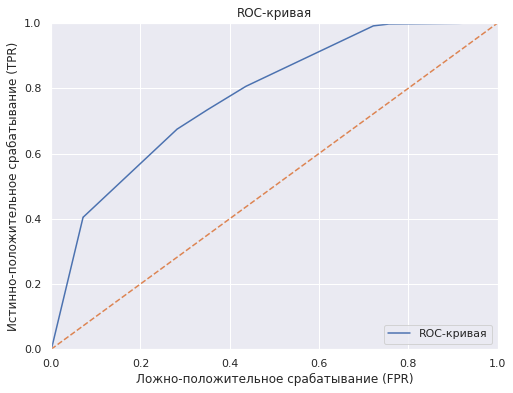

In [162]:
model =  DecisionTreeClassifier(random_state=12345, max_depth=5, class_weight='balanced')
model.fit(features_train, target_train)


predicted_test = model.predict(features_test)
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
test_f1_score = f1_score(target_test, predicted_test )
auc_roc = roc_auc_score(target_test, probabilities_one_test)

print('Значение F1-меры на тестовой выборке:', test_f1_score) 
print('Значение метрики AUC-ROC:', auc_roc)

sns.set(font_scale=1)
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)

plt.figure(figsize=(8, 6))  
plt.plot(fpr, tpr, label='ROC-кривая')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('Ложно-положительное срабатывание (FPR)')
plt.ylabel('Истинно-положительное срабатывание (TPR)')
plt.title('ROC-кривая')  
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.legend(loc='lower right')  
plt.grid(True)  
plt.show()

Необходимо добавить предсказания в датафрейм, чтобы в дальнейшем провести анализ прибыли, которая разработанная модель может принести за год

In [163]:
model =  DecisionTreeClassifier(random_state=12345, max_depth=5, class_weight='balanced')
model.fit(features_train, target_train)
predictions_test = model.predict(features_test)

In [164]:
hotel_test['prediction_test'] = predictions_test

In [165]:
hotel_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32343 entries, 0 to 32342
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   id                              32343 non-null  int64 
 1   is_canceled                     32343 non-null  int64 
 2   lead_time                       32343 non-null  int64 
 3   arrival_date_year               32343 non-null  int64 
 4   arrival_date_month              32343 non-null  object
 5   arrival_date_week_number        32343 non-null  int64 
 6   arrival_date_day_of_month       32343 non-null  int64 
 7   stays_in_weekend_nights         32343 non-null  int64 
 8   stays_in_week_nights            32343 non-null  int64 
 9   adults                          32343 non-null  int64 
 10  children                        32343 non-null  int64 
 11  babies                          32343 non-null  int64 
 12  meal                            32343 non-null

In [166]:
hotel_test.head(10)

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,prediction_test
0,6086,1,74,2017,January,1,1,1,0,2,...,0,0,A,0,0,Transient,0,0,1,1
1,6087,1,62,2017,January,1,1,2,2,2,...,0,0,A,0,0,Transient,0,1,4,0
2,6088,1,62,2017,January,1,1,2,2,2,...,0,0,A,0,0,Transient,0,1,4,0
3,6089,1,71,2017,January,1,1,2,2,1,...,0,0,A,0,0,Transient,0,1,4,0
4,6090,1,172,2017,January,1,1,2,5,2,...,0,0,A,0,0,Transient,0,0,7,1
5,6091,1,52,2017,January,1,1,2,5,1,...,0,0,A,0,0,Transient,0,0,7,1
6,6092,1,143,2017,January,1,2,1,1,2,...,0,0,A,1,0,Transient,0,1,2,0
7,6093,1,21,2017,January,1,2,1,3,2,...,0,0,A,0,0,Transient,0,1,4,0
8,6094,1,89,2017,January,1,2,1,3,2,...,0,0,E,0,0,Transient,0,0,4,1
9,6095,1,48,2017,January,1,2,1,4,2,...,0,0,A,1,0,Transient,0,2,5,0


Добавление прошло успешно.

Функция для подсчёта прибыли с учетом внедрения депозитов.

In [167]:
def count_revenue_with_deposit(row):
    room_cost = {
        'A': {'night_cost': 1000, 'cleaning_cost': 400},
        'B': {'night_cost': 800, 'cleaning_cost': 350},
        'C': {'night_cost': 600, 'cleaning_cost': 350},
        'D': {'night_cost': 550, 'cleaning_cost': 150},
        'E': {'night_cost': 500, 'cleaning_cost': 150},
        'F': {'night_cost': 450, 'cleaning_cost': 150},
        'G': {'night_cost': 350, 'cleaning_cost': 150},
    }

    season_coefficients = {
        'spring': 1.2,
        'summer': 1.4,
        'autumn': 1.2,
        'winter': 1.0,
    }

    #необходимые данные из строки
    room_type = row['reserved_room_type']  
    month = row['arrival_date_month']  
    week_nights = row['stays_in_week_nights']  #
    weekend_nights = row['stays_in_weekend_nights']  

    #стоимость и затраты на подготовку для данного типа номера
    price = room_cost[room_type]['night_cost']  #стоимость за ночь
    prepare_cost = room_cost[room_type]['cleaning_cost']  #стоимость подготовки номера

    #общее количество ночей
    total_nights = week_nights + weekend_nights
    
    #размер депозита в зависимости от предсказания модели
    if row['prediction_test'] == 1:
        deposit = 0.8 * price  #размер депозита составляет 80% от стоимости номера за одну ночь
    else:
        deposit = 0  #если бронь не отменяется, депозит не взимается
    
    # Расчет дохода
    if row['is_canceled'] == 0:  #если бронь не отменена
        # расчет количества ночей для подготовки (каждые две ночи)
        prepare_nights = math.floor((total_nights - 1) / 2)
        
        # сезонные коэффициенты при расчете дохода
        if month.lower() in season_coefficients:  # наличие месяца в сезонных коэффициентах
            season_multiplier = season_coefficients[month.lower()]  # коэффициент для месяца
        else:
            season_multiplier = 1.2  # если месяц не найден, используем дефолтное значение
        
        # расчет дохода от проживания
        revenue = season_multiplier * price * total_nights - prepare_cost - prepare_nights * prepare_cost
    else:  # если бронь отменена
        revenue = deposit - prepare_cost  # затраты на подготовку из депозита
    
    return revenue

In [168]:
total_revenue_deposit = hotel_test.apply(count_revenue_with_deposit, axis=1).sum()
print(total_revenue_deposit)

53481670.0


Прибыль при внедрении депозитов могла бы составить: 53481670.0

In [169]:
print(f"В случае внедрения депозита отель получит прибыль на {total_revenue_deposit - total_hotel_profit} больше, чем при использовании модели без депозита")

В случае внедрения депозита отель получит прибыль на 3704970.0 больше, чем при использовании модели без депозита


In [170]:
SYSTEMA_PROGNOZA=400000
total_profit_hotel_prognoz=total_revenue_deposit - total_hotel_profit-SYSTEMA_PROGNOZA
print(f"Учитывая стоимость системы прогнозирования: {total_profit_hotel_prognoz}")

Учитывая стоимость системы прогнозирования: 3304970.0


1. Использована OneHotEncoder из библиотеки scikit-learn для кодирования категориальных признаков в числовые значения, чтобы их можно было использовать в моделях.
2. Проведены оценки модели с использованием DecisionTreeClassifier, RandomForestClassifier  с использованием кросс-валидации (CV=5) и метрики f1. Также проведено вычисление качества модели LogisticRegression с кросс-валидацией (CV=5) и метрикой f1.
3. Лучшей моделью является DecisionTreeClassifier с глубиной дерева 5, F1-оценка: 0.6640659953773396.
4. 
- Значение F1-меры на тестовой выборке: 0.6370904177457494
- Значение метрики AUC-ROC: 0.7765707327368188
- Построена ROC-кривая.
5. Предсказания добавлены в датафрейм
6. Разработана функция для подсчёта прибыли с учетом внедрения депозитов. Прибыль при внедрении депозитов могла бы составить: 53481670.0
7. С учетом затрата на разработку модели отель получил бы на 3304970.0 рублей больше. 

### Шаг 5. Опишите портрет «ненадёжного» клиента

In [171]:
canceled_with_deposit = hotel_test.query('is_canceled==1 and prediction_test==1')

In [172]:
canceled_with_deposit.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8487 entries, 0 to 26034
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   id                              8487 non-null   int64 
 1   is_canceled                     8487 non-null   int64 
 2   lead_time                       8487 non-null   int64 
 3   arrival_date_year               8487 non-null   int64 
 4   arrival_date_month              8487 non-null   object
 5   arrival_date_week_number        8487 non-null   int64 
 6   arrival_date_day_of_month       8487 non-null   int64 
 7   stays_in_weekend_nights         8487 non-null   int64 
 8   stays_in_week_nights            8487 non-null   int64 
 9   adults                          8487 non-null   int64 
 10  children                        8487 non-null   int64 
 11  babies                          8487 non-null   int64 
 12  meal                            8487 non-null  

In [173]:
canceled_with_deposit.head(10)

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,prediction_test
0,6086,1,74,2017,January,1,1,1,0,2,...,0,0,A,0,0,Transient,0,0,1,1
4,6090,1,172,2017,January,1,1,2,5,2,...,0,0,A,0,0,Transient,0,0,7,1
5,6091,1,52,2017,January,1,1,2,5,1,...,0,0,A,0,0,Transient,0,0,7,1
8,6094,1,89,2017,January,1,2,1,3,2,...,0,0,E,0,0,Transient,0,0,4,1
10,6096,1,31,2017,January,1,2,1,4,2,...,0,0,G,0,0,Transient,0,0,5,1
13,6099,1,23,2017,January,1,3,0,2,2,...,0,0,D,0,0,Transient,0,0,2,1
14,6100,1,46,2017,January,1,3,0,3,2,...,0,0,G,0,0,Transient,0,0,3,1
15,6102,1,149,2017,January,1,3,0,5,2,...,0,0,G,0,0,Transient,0,0,5,1
16,6103,1,44,2017,January,1,3,2,5,2,...,0,0,A,0,0,Transient,0,0,7,1
18,6105,1,6,2017,January,1,4,0,1,1,...,0,0,A,0,0,Transient,0,0,1,1


In [174]:
canceled_with_deposit.describe()

,id,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights,prediction_test
count,8487.000000,8487.0,8487.000000,8487.0,8487.000000,8487.000000,8487.000000,8487.000000,8487.000000,8487.000000,8487.000000,8487.000000,8487.000000,8487.000000,8487.000000,8487.000000,8487.0,8487.0,8487.000000,8487.0
mean,43976.032049,1.0,122.794038,2017.0,17.647107,15.666195,0.831154,2.355485,1.879934,0.072817,0.000943,0.001885,0.002121,0.006363,0.073642,0.550842,0.0,0.0,3.186638,1.0
std,15139.471747,0.0,83.109052,0.0,8.378508,8.700582,0.854005,1.269881,0.465730,0.331225,0.030689,0.043381,0.068623,0.299984,0.365069,6.325262,0.0,0.0,1.556023,0.0
min,6086.000000,1.0,0.000000,2017.0,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.000000,1.0
25%,46198.500000,1.0,56.000000,2017.0,11.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,2.000000,1.0
50%,49070.000000,1.0,111.000000,2017.0,18.000000,15.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,3.000000,1.0
75%,51942.000000,1.0,173.000000,2017.0,24.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,4.000000,1.0
max,91576.000000,1.0,373.000000,2017.0,35.000000,31.000000,4.000000,6.000000,4.000000,3.000000,1.000000,1.000000,4.000000,26.000000,5.000000,183.000000,0.0,0.0,10.000000,1.0


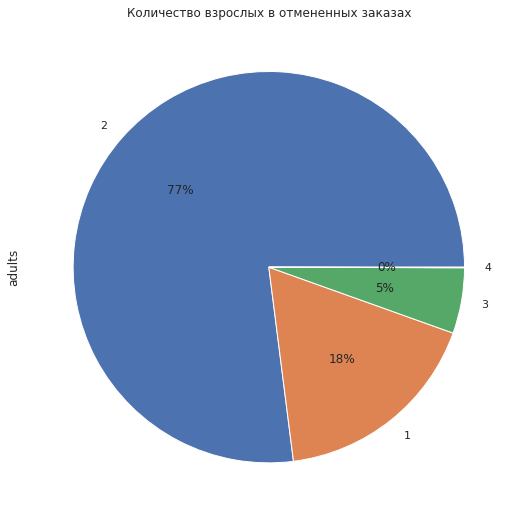

In [175]:
canceled_with_deposit['adults'].value_counts().plot( kind = 'pie',figsize=(9,9), autopct = '%1.0f%%',
title = 'Количество взрослых в отмененных заказах');

В большинстве случаев при отмене было зарегестрировано 2 человека.

In [176]:
canceled_with_deposit['children'].value_counts(normalize=True)

0    0.948156
1    0.030989
2    0.020738
3    0.000118
Name: children, dtype: float64

In [177]:
canceled_with_deposit['babies'].value_counts(normalize=True)

0    0.999057
1    0.000943
Name: babies, dtype: float64

В большинстве случаев отмены у постояльцев не было детей

In [178]:
canceled_with_deposit['customer_type'].value_counts(normalize=True)

Transient          0.916225
Transient-Party    0.078944
Contract           0.004124
Group              0.000707
Name: customer_type, dtype: float64

Отмена не связана с договором или групповым заездом.

In [179]:
canceled_with_deposit['is_repeated_guest'].value_counts(normalize=True)

0    0.998115
1    0.001885
Name: is_repeated_guest, dtype: float64

Гость не бронировал ранее номер

In [180]:
canceled_with_deposit['required_car_parking_spaces'].value_counts(normalize=True)

0    1.0
Name: required_car_parking_spaces, dtype: float64

Гость также не запрашивает автомобиль

Далее рассмотрим количество отмененных бронирований с учетом времени, которое оставалось до заезда. Так как записей много, проведу группировку данных и на основе их найду способ для лучшего вычисления информации.

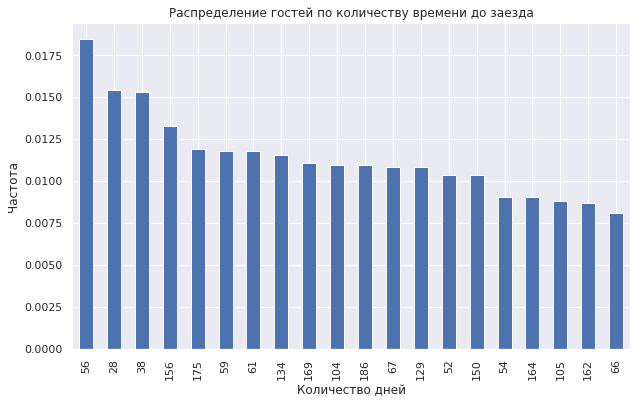

In [181]:
lead_time_counts = canceled_with_deposit['lead_time'].value_counts(normalize=True)

plt.figure(figsize=(10, 6))
lead_time_counts.head(20).plot(kind='bar')
plt.title('Распределение гостей по количеству времени до заезда')
plt.xlabel('Количество дней')
plt.ylabel('Частота')
plt.show()

In [182]:
total_records = canceled_with_deposit.shape[0]
conditions = {
    'менее 30': canceled_with_deposit[canceled_with_deposit['lead_time'] < 30].shape[0],
    'более 30 и менее или равно 60': canceled_with_deposit[(canceled_with_deposit['lead_time'] > 30) 
                                                           & (canceled_with_deposit['lead_time'] <= 60)].shape[0],
    'более 60 и менее или равно 90': canceled_with_deposit[(canceled_with_deposit['lead_time'] > 60) 
                                                           & (canceled_with_deposit['lead_time'] <= 90)].shape[0],
    'более 90': canceled_with_deposit[canceled_with_deposit['lead_time'] > 90].shape[0]
}


for key in conditions:
    conditions[key] = (conditions[key] / total_records) * 100


lead_time_counts = pd.DataFrame(conditions.items(), columns=['Условие', 'Процент'])
display (lead_time_counts)

,Условие,Процент
0,менее 30,12.713562
1,более 30 и менее или равно 60,15.176152
2,более 60 и менее или равно 90,13.019913
3,более 90,58.748674


Около 60% постояльцев отменили номера, которые были забранированы за 90 дней.

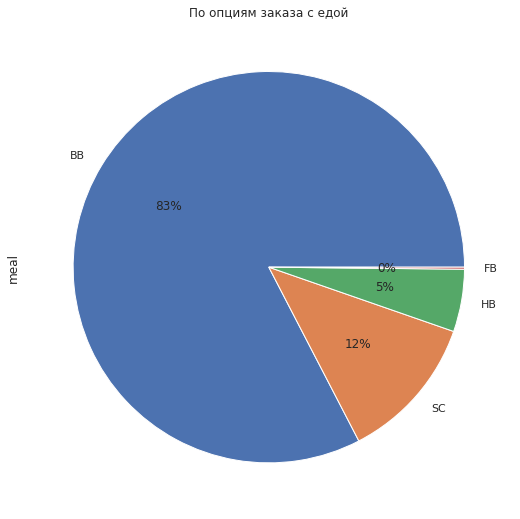

In [183]:
canceled_with_deposit['meal'].value_counts().plot( kind = 'pie',figsize=(9,9), autopct = '%1.0f%%',
title = 'По опциям заказа с едой');

В 83% гости заказывали только завтрак, в 12% ничего, в 5% завтрак и обед.

In [184]:
canceled_with_deposit['total_nights'].value_counts(normalize=True)

3     0.329445
2     0.245788
4     0.167550
1     0.103570
5     0.067633
7     0.060092
6     0.018499
8     0.004949
10    0.001296
9     0.001178
Name: total_nights, dtype: float64

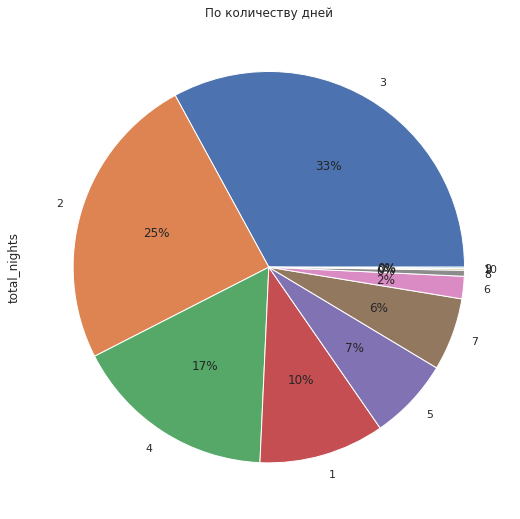

In [185]:
canceled_with_deposit['total_nights'].value_counts().plot( kind = 'pie',figsize=(9,9), autopct = '%1.0f%%',
title = 'По количеству дней');

Чаще всего заказы отменяли гости, хотевшие остановиться на 2-4 ночи (знаю о слишком большом количестве данных для круговой диаграммы, но так нагляднее и быстрее понять)

In [120]:
canceled_with_deposit['total_of_special_requests'].value_counts(normalize=True)

0    1.0
Name: total_of_special_requests, dtype: float64

У гостей не было специальных меток.

Самым ненадежным клиентом является человек, бронирующий отель за более, чем 60 дней, хотящий остановиться на 2-4 ночи, заказывавший только завтрак или ничего, не бронирующий место под автомобиль, не имеющий специальных отметок и ранее не останавливающийся в этом отеле.

### Шаг 6. Напишите общий вывод

1. Произведено открытие файлов с данными.
- получена первичная информация о двух датафреймах: hotel_train  и hotel_test;
- выведена описательная информация о датафреймах, которую можно будет использовать при дальнейшем анализе в предобработке данных.

2. Предобработка и исследовательский анализ.
- проверены пропуски и дубликаты;
- произведена работа с неявными дубликатами, убраны лишние пробелы и неявные дубликаты, которые могут вызвать проблемы в дальнейшем;
- получена информация обо всех столбцах в датафреймах;
- убраны странные записи в датафрейме с 0 количеством взрослых;
- 'lead_time', 'adults', 'children', 'babies' переведены из float64 в int64;
- сброешны индексы.

3. Произведён анализ бизнес-задачи.
- написана функция def calculate_hotel_profit для расчёта прибыли отеля до внедрения депозитов.

4. Разработка модели ML.
- произведена подготовка данных перед использований моделей;
- использованы DecisionTreeClassifier, RandomForestClassifier,  LogisticRegression с кросс-валидацией (CV=5) и метрикой f1;
- к  DecisionTreeClassifier и RandomForestClassifier для удобства добавлен подсчёт времени;
- лучшей моделью является DecisionTreeClassifier с глубиной дерева 5, она использована для предсказаний отмены;
- информация добавлена в датафрейм;
- написана функция def count_revenue_with_deposit для подсчёта прибыли с учетом внедрения депозитов.

5. Описан портрет "ненадёжного" клиента. Самым ненадежным клиентом является человек, бронирующий отель за более, чем 60 дней, хотящий остановиться на 2-4 ночи, заказывавший только завтрак или ничего, не бронирующий место под автомобиль, не имеющий специальных отметок и ранее не останавливающийся в этом отеле.

Разработана функция для подсчёта прибыли с учетом внедрения депозитов. Прибыль при внедрении депозитов могла бы составить: 53481670.0. С учетом затрата на разработку модели отель получил бы на 3304970.0 рублей больше.

Заказчик может вводить систему депозитов, также может ввести минимальное количество дней до отдыха (90 дней) или внести какие-либо иные правки по своему усмотрению, связанные с тем, что люди, бронирующие отель за более чем 60 дней более склонны к отмене. 